## Corrective RAG 
* 기존은 retrieve를 잘하기 위한 re-write 였다면, 이번에는 Web search 를 통해 re-write를 진행
* Web search 를 위한 API 가 필요 -> tavily

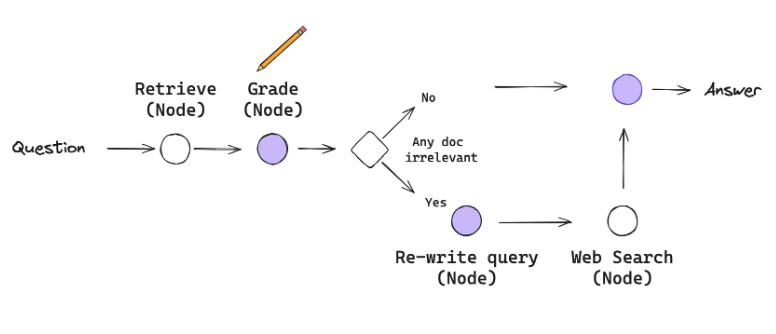

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

from langchain_chroma import Chroma

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str
    
graph_builder = StateGraph(AgentState)

In [4]:
def retrieve(state: AgentState) -> AgentState:
    query = state['query']
    docs = retriever.invoke(query)
    return {'context':docs}

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = 'gpt-4o')

In [6]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull('rlm/rag-prompt')
generate_llm = ChatOpenAI(model = 'gpt-4o', max_completion_tokens=100)

def generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    response = rag_chain.invoke({'question': query , 'context': context})
    return {'answer':response}

In [7]:
from typing import Literal
relevance_doc_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant','irrelevant']:
    query = state['query']
    context = state['context']
    # print(f'context == {context}')
    
    doc_relevance_chain = relevance_doc_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})
    # print(f'doc relevance response : {response}')
    if response['Score']==1:
        return 'relevant'
    
    return 'irrelevant'

In [8]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser


rewrite_prompt = PromptTemplate.from_template("""사용자의 질문을 보고, 웹 검색에 용이하게 사용자의 질문을 수정해주세요.
질문: {query}
""")

def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query':query})
    print(f'rewrtie question : {response}')
    return {'query' : response}

In [9]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    topic="general",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
    search_depth="advanced"
)

def web_search(state:AgentState):
    query = state['query']
    results = tavily_search_tool.invoke(query)
    print(f'web search results : {results}')
    return {'context': results}


In [10]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)

# graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('web_search', web_search)

In [11]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance,
    {
        'relevant':'generate',
        'irrelevant':'web_search'
    }
)
# graph_builder.add_edge('rewrite','web_search')
graph_builder.add_edge('web_search', 'generate')
graph_builder.add_edge('generate', END)

In [12]:
graph = graph_builder.compile()

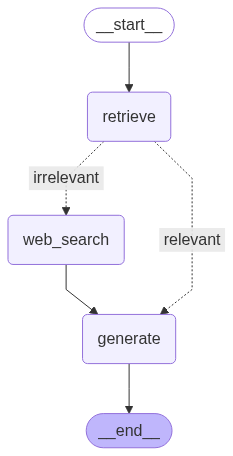

In [13]:
graph

In [14]:
initial_state = {'query': '연봉 7천만원인 거주자의 소득세는 얼마인가요?'}
graph.invoke(initial_state)

{'query': '연봉 7천만원인 거주자의 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n종합소득\n┌───────────────┐\n│ 과

In [15]:
initial_state = {'query': '연봉 6천만원인 거주자의 소득세는 얼마인가요?'}
graph.invoke(initial_state)

{'query': '연봉 7천만원인 거주자의 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n종합소득\n┌───────────────┐\n│ 과

In [16]:
initial_state = {'query': '역삼역 맛집을 추천해주세요.'}
graph.invoke(initial_state)

web search results : [{'url': 'https://m.blog.naver.com/je3355je/223613149295', 'content': '1 한식 뚝배기양평해장국 역삼직영점 뼈해장국 서울 강남구 테헤란로27길 36 1층 뚝배기양평해장국 역삼역 8번 출구에서 372m 6 한식 오성식당 역삼 쌈돼지김치찌개 서울 강남구 테헤란로33길 13 2층 역삼역 8번 출구에서 335m 9 한식술집 카즈야 김치우동 서울 강남구 테헤란로27길 8-4 늘봄빌딩 1층 역삼역 8번 출구에서 206m 10 분식 민들레떡볶이 우삼겹떡볶이+튀김세트 서울 강남구 논현로94길 11 2층 역삼역 7번 출구에서 217m 18 이탈리아식 지아니스나폴리 역삼 본점 점심 피자 서울 강남구 논현로94길 15 B1층 역삼역 7번 출구에서 267m 21 카페 뮬리 아메리카노 서울 강남구 논현로93길 6 1층 역삼역 6번 출구에서 160m 22 카페 터프커피 자몽허니블랙티 서울 강남구 테헤란로25길 19 1층 역삼역 6번 출구에서 187m 24 카페 지오바네커피 아인슈페너 서울 강남구 논현로98길 5 1층 101호 역삼역 7번 출구에서 316m 25 카페 루스터 아몬드 아인슈페너 서울 강남구 논현로86길 22 1층 역삼역 1번 출구에서 319m'}, {'url': 'https://www.diningcode.com/list.dc?query=%EC%97%AD%EC%82%BC', 'content': '1. 돝고기506 역삼역 · 2. 대우부대찌개 역삼 · 3. 불이아 역삼점 · 4. 육전식당 강남역 · 5. 이도곰탕 본점 · 6. 나이스샤워 강남역 · 7. 바스버거 역삼 · 8. 바게트케이 역삼역.'}, {'url': 'https://blog.naver.com/papa575/223307768987', 'content': '카테고리 이동 냠냠짭짭후루룩짭짭 · 1. 화덕고깃간 · 2. 해담채 · 3. 그릴아지사이 · 4. 보슬보슬 · 6. 파파야리프(?) · 7. 갓포돈 · 8. 원당뼈다귀'

{'query': '역삼역 맛집을 추천해주세요.',
 'context': [{'url': 'https://m.blog.naver.com/je3355je/223613149295',
   'content': '1 한식 뚝배기양평해장국 역삼직영점 뼈해장국 서울 강남구 테헤란로27길 36 1층 뚝배기양평해장국 역삼역 8번 출구에서 372m 6 한식 오성식당 역삼 쌈돼지김치찌개 서울 강남구 테헤란로33길 13 2층 역삼역 8번 출구에서 335m 9 한식술집 카즈야 김치우동 서울 강남구 테헤란로27길 8-4 늘봄빌딩 1층 역삼역 8번 출구에서 206m 10 분식 민들레떡볶이 우삼겹떡볶이+튀김세트 서울 강남구 논현로94길 11 2층 역삼역 7번 출구에서 217m 18 이탈리아식 지아니스나폴리 역삼 본점 점심 피자 서울 강남구 논현로94길 15 B1층 역삼역 7번 출구에서 267m 21 카페 뮬리 아메리카노 서울 강남구 논현로93길 6 1층 역삼역 6번 출구에서 160m 22 카페 터프커피 자몽허니블랙티 서울 강남구 테헤란로25길 19 1층 역삼역 6번 출구에서 187m 24 카페 지오바네커피 아인슈페너 서울 강남구 논현로98길 5 1층 101호 역삼역 7번 출구에서 316m 25 카페 루스터 아몬드 아인슈페너 서울 강남구 논현로86길 22 1층 역삼역 1번 출구에서 319m'},
  {'url': 'https://www.diningcode.com/list.dc?query=%EC%97%AD%EC%82%BC',
   'content': '1. 돝고기506 역삼역 · 2. 대우부대찌개 역삼 · 3. 불이아 역삼점 · 4. 육전식당 강남역 · 5. 이도곰탕 본점 · 6. 나이스샤워 강남역 · 7. 바스버거 역삼 · 8. 바게트케이 역삼역.'},
  {'url': 'https://blog.naver.com/papa575/223307768987',
   'content': '카테고리 이동 냠냠짭짭후루룩짭짭 · 1. 화덕고깃간 · 2. 해담채 · 3. 그릴아지사이 · 4. 보슬보슬 ·

* Rewrite 가 필요한 node일까? >> 굳이 필요없다.